# Libraries

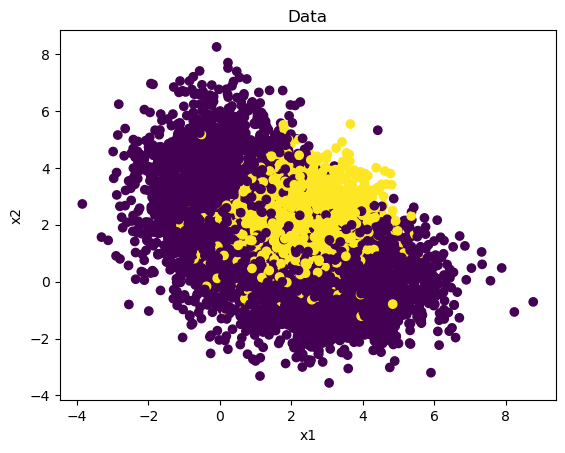

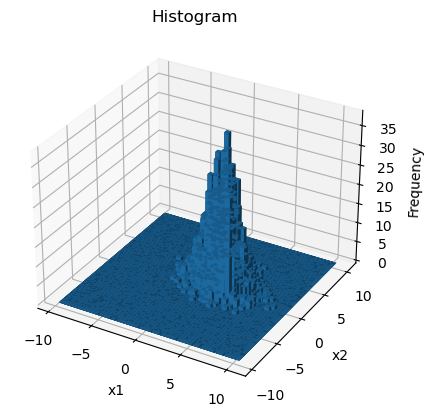

In [1]:
import matplotlib.pyplot as plt
import numpy as np
p = [0.65, 0.35]
m = [[3, 0], [0, 3], [2, 2]]
c = [[[2, 0], [0, 1]], [[1, 0], [0, 2]], [[1, 0], [0, 1]]]
w = [0.5, 0.5]
sample_size = 10000
labels = np.random.choice(2, sample_size, p=p)
samples = np.zeros((2, sample_size))
for i in range(sample_size):
    if(labels[i] == 0):
        inter_class = np.random.choice(2, 1, p=w)
        if(inter_class == 0):
            samples[:, i] = np.random.multivariate_normal(m[0], c[0])
        if(inter_class == 1):
            samples[:, i] = np.random.multivariate_normal(m[1], c[1])
    if(labels[i] == 1):
        samples[:, i] = (np.random.multivariate_normal(m[2], c[2]))
# Plot the data
plt.scatter(samples[0], samples[1], c=labels)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Data')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(samples[0], samples[1], bins=100, range=[[-10, 10], [-10, 10]])
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Frequency')
plt.title('Histogram')
plt.show()

# Classifier

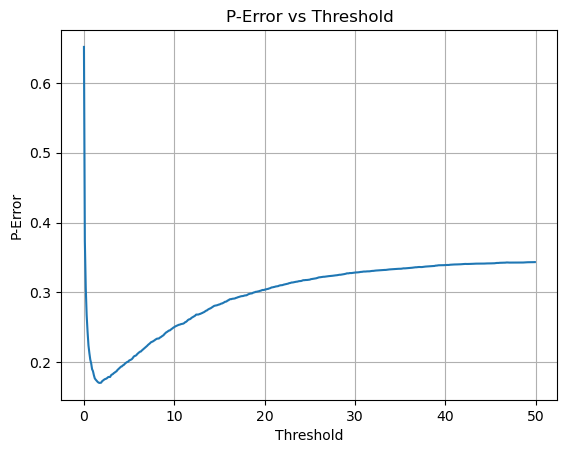

In [4]:
loss = [[0, 1], [1, 0]]
def cal_prob(x, m, c):
    return np.exp(-0.5 * (x - m).T @ np.linalg.inv(c) @ (x - m)) / np.sqrt((2 * np.pi) ** 2 * np.linalg.det(c))

# def ERM(x):
#     risk = np.zeros(2)
#     for i in range(2):
#         for j in range(2):
#             if(j == 1):
#                 risk[i] += loss[i, j] * p[j] * cal_prob(x, m[2], c[2])
#             if(j == 0):
#                 risk[i] += loss[i, j] * p[j] * (w1 * cal_prob(x, m[0], c[0]) + w2 * cal_prob(x, m[1], c[1]))
#     return np.argmin(risk)


def classifier(x, threshold, m, c):
    likelihood_ratio = cal_prob(x, m[2], c[2]) / (w[0] * cal_prob(x, m[0], c[0]) + w[1] * cal_prob(x, m[1], c[1]))
    if(likelihood_ratio > threshold):
        return 1
    else:
        return 0
thresholds = np.arange(0, 50, 0.1)
results = np.zeros(sample_size)
tp = np.zeros(len(thresholds))
fp = np.zeros(len(thresholds))
fn = np.zeros(len(thresholds))
for t in range(len(thresholds)):
    for i in range(sample_size):
        results[i] = classifier(samples[:,i], thresholds[t], m, c)
        tp[t] += (results[i] == labels[i]) and (labels[i] == 1)
        fp[t] += (results[i] != labels[i]) and (labels[i] == 0)
        fn[t] += (results[i] != labels[i]) and (labels[i] == 1)

# calculate the probability of error
p_error = (fn + fp) / sample_size
plt.plot(thresholds, p_error)
plt.xlabel('Threshold')
plt.ylabel('P-Error')
plt.title('P-Error vs Threshold')
plt.grid()
plt.show()
# find the best threshold
best_threshold = thresholds[np.argmin(p_error)]
print('Best Threshold: ', best_threshold)
print('P-Error: ', p_error[np.argmin(p_error)])
tp_rate = tp / np.sum(labels == 1)
fp_rate = fp / np.sum(labels == 0)


tp_theoritical = 0
fp_theoritical = 0
fn_theoritical = 0

for i in range(sample_size):
    results[i] = classifier(samples[:,i], p[0]/p[1], m, c)
    tp_theoritical += (results[i] == labels[i]) and (labels[i] == 1)
    fp_theoritical += (results[i] != labels[i]) and (labels[i] == 0)
    fn_theoritical += (results[i] != labels[i]) and (labels[i] == 1)
p_error_theoritical = (fn_theoritical + fp_theoritical) / sample_size
print('Theoritical P-Error: ', p_error_theoritical)

plt.plot(fp_rate, tp_rate, fp_rate[int(np.argmin(p_error))], tp_rate[int(np.argmin(p_error))], 'gx', fp_theoritical / np.sum(labels == 0), tp_theoritical / np.sum(labels == 1), 'rx')
plt.xlabel('False Alarm Rate')
plt.ylabel('Hit Rate')
plt.title('ROC')
plt.grid()
plt.show()


## Part B

In [2]:
w0_class = []
w1_class = []
for i in range(sample_size):
    if labels[i] == 0:
        w0_class.append(samples[:, i])
    else:
        w1_class.append(samples[:, i])
w0_class = np.array(w0_class)
w1_class = np.array(w1_class)
m_est_0 = np.mean(w0_class, axis=0)
m_est_1 = np.mean(w1_class, axis=0)
s0 = np.cov(np.transpose(w0_class))
s1 = np.cov(np.transpose(w0_class))
sw = s0 + s1
sb = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        sb[i, j] = (m_est_0[i] - m_est_1[i]) * (m_est_0[j] - m_est_1[j])
sx = np.linalg.inv(sw) @ sb
print(sx)
# Solving the generalized eigen value problem 
eig_vals, eig_vecs = np.linalg.eig(sx)
print('Eig Values: ', eig_vals, 'Eig Vectors: ', eig_vecs)
# Find the best projection vector 
w = eig_vecs[:, np.argmax(eig_vals)]
print('Best Projection Vector: ', w)
proj_samples = np.matmul(w, samples)
proj_m_est = [np.matmul(w, m_est_0), np.matmul(w, m_est_1)]
proj_s = [np.matmul(np.matmul(w, s0), w), np.matmul(np.matmul(w, s1), w)]
print(proj_m_est, proj_s)

[[0.07779684 0.08311776]
 [0.07901801 0.08442246]]
Eig Values:  [-1.38777878e-17  1.62219296e-01] Eig Vectors:  [[-0.73008948 -0.70157902]
 [ 0.68335155 -0.71259167]]
Best Projection Vector:  [-0.70157902 -0.71259167]
[-2.131363825594385, -2.834269981341479] [1.5228677334519665, 1.5228677334519665]


In [10]:
def guass_prob(x, m, c):
    return 1/np.sqrt(2 * np.pi * c**2) * np.exp(-0.5 * np.power((x - m), 2) / c**2)
def classifier(x, threshold, m, s):
    likelihood_ratio = guass_prob(x, m[1], s[1]) / guass_prob(x, m[0], s[0])
    if(likelihood_ratio > threshold):
        return 1
    else:
        return 0

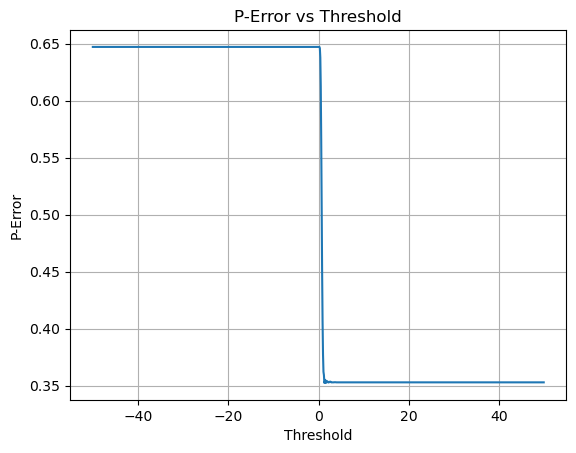

Best Threshold:  1.300000000000729
P-Error:  0.3524
Theoritical P-Error:  0.3527


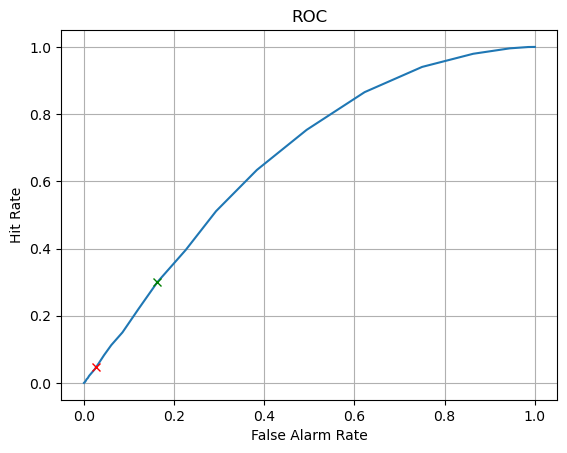

In [11]:
thresholds = np.arange(-50, 50, 0.1)
results = np.zeros(sample_size)
tp = np.zeros(len(thresholds))
fp = np.zeros(len(thresholds))
fn = np.zeros(len(thresholds))
for t in range(len(thresholds)):
    for i in range(sample_size):
        results[i] = classifier(proj_samples[i], thresholds[t], proj_m_est, proj_s)
        tp[t] += (results[i] == labels[i]) and (labels[i] == 1)
        fp[t] += (results[i] != labels[i]) and (labels[i] == 0)
        fn[t] += (results[i] != labels[i]) and (labels[i] == 1)

# calculate the probability of error
p_error = (fn + fp) / sample_size
plt.plot(thresholds, p_error)
plt.xlabel('Threshold')
plt.ylabel('P-Error')
plt.title('P-Error vs Threshold')
plt.grid()
plt.show()
# find the best threshold
best_threshold = thresholds[np.argmin(p_error)]
print('Best Threshold: ', best_threshold)
print('P-Error: ', p_error[np.argmin(p_error)])
tp_rate = tp / np.sum(labels == 1)
fp_rate = fp / np.sum(labels == 0)
tp_theoritical = 0
fp_theoritical = 0
fn_theoritical = 0

for i in range(sample_size):
    results[i] = classifier(proj_samples[i], p[0]/p[1], proj_m_est, proj_s)
    tp_theoritical += (results[i] == labels[i]) and (labels[i] == 1)
    fp_theoritical += (results[i] != labels[i]) and (labels[i] == 0)
    fn_theoritical += (results[i] != labels[i]) and (labels[i] == 1)
p_error_theoritical = (fn_theoritical + fp_theoritical) / sample_size
print('Theoritical P-Error: ', p_error_theoritical)

plt.plot(fp_rate, tp_rate, fp_rate[int(np.argmin(p_error))], tp_rate[int(np.argmin(p_error))], 'gx', fp_theoritical / np.sum(labels == 0), tp_theoritical / np.sum(labels == 1), 'rx')
plt.xlabel('False Alarm Rate')
plt.ylabel('Hit Rate')
plt.title('ROC')
plt.grid()
plt.show()
